In [1]:
import datetime as dt
import os
from timeit import default_timer as timer

import pandas as pd
from sklearn.model_selection import train_test_split

from feature.time_lag import lag_features, lag_target
import feature.time_categorical as tc
import feature.feature_selection as fs
import feature.feature_selection_external as fes
import feature.party_selection as ps
import feature.party_feature_selection as pfs
import feature.party_feature_temporal_mask as pftm
import feature.time_stationarization as ts
import feature.feature_transformation as ft
import model.model_init as mi
from forecast import model_selection, batch_learning, online_learning, mix_learning
from evaluation import evaluation
import model.model_init_batch as mib
import model.model_init_mix as mim

In [53]:
data

,wp1,wp2,wp3,wp4,wp5,wp6,wp7
2009-07-01 00:00:00,0.045,0.233,0.494,0.105,0.056,0.118,0.051
2009-07-01 01:00:00,0.085,0.249,0.257,0.105,0.066,0.066,0.051
2009-07-01 02:00:00,0.020,0.175,0.178,0.033,0.015,0.026,0.000
2009-07-01 03:00:00,0.060,0.085,0.109,0.022,0.010,0.013,0.000
2009-07-01 04:00:00,0.045,0.032,0.079,0.039,0.010,0.000,0.000
...,...,...,...,...,...,...,...
2012-06-28 08:00:00,0.060,0.307,0.375,0.160,0.131,0.184,0.126
2012-06-28 09:00:00,0.085,0.217,0.346,0.121,0.066,0.118,0.177
2012-06-28 10:00:00,0.085,0.090,0.296,0.220,0.020,0.184,0.202
2012-06-28 11:00:00,0.090,0.021,0.247,0.303,0.005,0.224,0.177


In [43]:
import numpy as np
import random
import matplotlib.pyplot as plt

def calculate_scenario(data, external_data, P_list, methods_to_train, horizon, number_of_lags, analyze_ratio,
                       selection_ratio, feature_transformation, time_stationarization, datetime_features,
                       feature_selection, external_feature_selection,
                       selection_criterion, party_feature_selection, party_feature_temporal_mask,
                       show_plots):
    # Time measurements
    t_start = timer()
    print('Run time start:', dt.datetime.now())
    time_measures = {'script_start': dt.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")}

    forecast_tot = {method.name: {} for method in methods_to_train}
    err_tot = {method.name: {} for method in methods_to_train}
    select_tot = {}
    y_tot = {}
    for target in P_list:
        ###########################
        ### Feature engineering ###
        ###########################

        # Copy data to feature matrix
        X = data.copy()

        #### Lag Selection  ####
        # Split data to avoid leakage
        offline_split, _ = train_test_split(X, train_size=analyze_ratio, shuffle=False)

        # Stationarize time series for analysis
        offline_split_stationary = time_stationarization.make_stationary(
            feature_transformation.transform_data(offline_split))

        # Get party selection
        additional_info = [i for i in P_list if i != target]
        party_selection = selection_criterion.select_parties(offline_split_stationary, target, additional_info)
        X = X[party_selection + [target]]

        # Get lags
        target_lags = feature_selection.select_features(offline_split_stationary[target], number_of_lags, horizon)
        party_info_lags = party_feature_selection.select_features(offline_split_stationary, target, party_selection,
                                                                  target_lags)

        # Add categorical features
        if datetime_features:
            X = tc.add_datetime_features(X, datetime_features)

        external_features = external_feature_selection.select_features(external_data, target, party_selection, horizon)
        if not external_features.empty:
            X = fes.add_modified_external_features(X, external_features)

        # Lag features and target
        if party_info_lags:
            X = lag_features(X, party_info_lags)
        if target_lags:
            X = lag_target(X, target, target_lags)
        time_drop = max(target_lags) if target_lags else horizon
        X.drop(index=data.index[range(time_drop)], inplace=True)

        # Drop indices of offline_split
        offline_X = X.loc[offline_split.index.delete(range(time_drop))]
        X.drop(index=offline_split.index.delete(range(time_drop)), inplace=True)

        # Extract target labels to avoid leakage
        offline_Y = offline_X.pop(target)
        Y = X.pop(target)
        offline_X.drop(columns=party_selection, inplace=True)
        X.drop(columns=party_selection, inplace=True)
        print(f"target {target}: {X.reindex(sorted(X), axis=1, copy=False).columns.tolist()}")

        ######################
        ### Data partition ###
        ######################
        selection_size = int(data.shape[0] * selection_ratio)
        #print(len(offline_X))
        #######################
        ### Model Selection ###
        #######################
        if party_feature_temporal_mask.data_selection == "train":
            offline_X = party_feature_temporal_mask.mask_features(offline_X, target, party_selection)
        elif party_feature_temporal_mask.data_selection == "test":
            X = party_feature_temporal_mask.mask_features(X, target, party_selection)
        elif party_feature_temporal_mask.data_selection == "both":
            joined = pd.concat([offline_X, X])
            joined = party_feature_temporal_mask.mask_features(joined, target, party_selection)
            offline_X = joined.loc[offline_X.index]
            X = joined.loc[X.index]
            del joined
        else:
            raise ValueError("Data mask selection unknown")

        ##############################
        ### Model Training/Testing ###
        ##############################

        # Online models centralized
        forecasts = {}
        for method in methods_to_train:
            if isinstance(method, mi.OnlineRegressorMethod):
                #print(X)
                _ = model_selection.online_to_batch_deterministic(offline_X, offline_Y, selection_size, method)
                forecasts[method.name] = online_learning.deterministic(X, Y, horizon, method)
            elif isinstance(method, mib.BatchRegressorMethod):
                forecasts[method.name] = batch_learning.deterministic(offline_X, offline_Y, X, method)
            elif isinstance(method, mim.MixRegressorMethod):
                _ = mix_learning.batch_deterministic(offline_X, offline_Y, X, method)
                method.transfer_params(offline_X)
                forecasts[method.name] = mix_learning.online_deterministic(X, Y, horizon, method)
        
        ########################
        ### Model Evaluation ###
        ########################
        forecasts = pd.DataFrame(forecasts, index=Y.index)

        errors = evaluation.deterministic_evaluation(Y, forecasts)

        for method in methods_to_train:
            forecast_tot[method.name][target] = forecasts[method.name]
            err_tot[method.name][target] = {metric: errors[method.name][metric] for metric in ['MASE', 'MAE', 'RMSE']}
        select_tot[f'Selection_to_{target}'] = {party: (party in party_selection) for party in P_list}
        y_tot[target] = Y

    # Check run time
    t_end = timer()
    print('Run time end:', dt.datetime.now())
    print('Run time duration [min]:', round((t_end - t_start) / 60, 2))
    time_measures['script_end'] = dt.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")

    #######################
    ### Result Analysis ###
    #######################

    if show_plots:
        # Concatenate forecasts and real values
        forecasts_result = pd.concat([forecasts, Y.rename('Real')], axis=1)

        # Forecast plots
        for method in methods_to_train:
            forecasts_result[['Real', method.name]].plot(title='Forecasts', fontsize=25)

        # Error plots
        for metric in ['APE', 'AE', 'SE', 'OMAPE', 'OMAE', 'ORMSE']:
            online_error = {method.name: errors[method.name][metric] for method in methods_to_train}
            pd.DataFrame(online_error).plot(title=metric, fontsize=25)

    return err_tot, select_tot, forecast_tot, y_tot

            A         D
0    4.000000  3.000000
1    3.995004  3.099833
2    3.980067  3.198669
3    3.955336  3.295520
4    3.921061  3.389418
..        ...       ...
295  2.661681  2.058969
296  2.757317  2.029894
297  2.855379  2.010513
298  2.954885  2.001018
299  3.054842  2.001505

[300 rows x 2 columns]


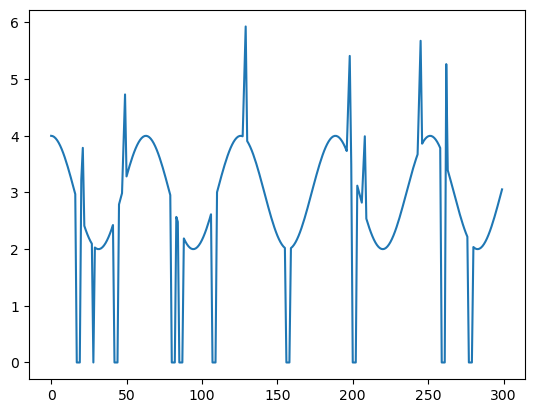

In [3]:

# 创建一个示例DataFrame
data = pd.DataFrame()
data['A']=np.cos(np.arange(0, 30, 0.1))+3
data['D']=np.sin(np.arange(0, 30, 0.1))+3
df = pd.DataFrame(data)

# 定义一个函数，用于在DataFrame中插入尖刺

def insert_spikes(df, n_spikes, width_range, ratio=0.5,seed=0):
    random.seed(seed)
    for column in df.columns:
        # Calculate the average of the selected range
        avg = df[column].mean()
        #print(column)

        for _ in range(n_spikes):
            # Randomly select the position and width of the spike insertion
            spike_position = random.randint(0, len(df) - 1)
            spike_width = random.randint(width_range[0], width_range[1])

            # Set the peak and width for the spike
            start = max(0, spike_position - spike_width // 2)
            end = min(len(df), spike_position + spike_width // 2)

            avg = np.average(df.loc[start:end, column]) * ratio
            # Update the DataFrame
            num_points = end - start + 1
            if len(df.loc[start:end, column])==num_points:
                #print(start,end,num_points)
                #print(avg)
                df.loc[start:end, column] += np.linspace(0, avg, num=num_points)

    return df

def set_zero(df, n_spikes, width_range,seed=2):
    random.seed(seed)
    for column in df.columns:
        for _ in range(n_spikes):
            spike_position = random.randint(0, len(df) - 1)
            spike_width = random.randint(width_range[0], width_range[1])
            # Set the peak and width for the spike
            start = max(0, spike_position - spike_width // 2)
            end = min(len(df), spike_position + spike_width // 2)
            # Update the DataFrame
            num_points = end - start + 1
            if len(df.loc[start:end, column])==num_points:
                df.loc[start:end, column] = np.linspace(0, 0, num=num_points)
    return df

# 使用函数插入尖刺
n_spikes = 10
width_range = (1,3)
result_df = insert_spikes(df, n_spikes, width_range,0.5)
result_df = set_zero(result_df, n_spikes, width_range)
print(result_df)
plt.plot(result_df['A'])

In [12]:
data_lst[3]

,wp1,wp2,wp3,wp4,wp5,wp6,wp7
0,0.045,0.23300,0.494,0.105,0.056,0.118,0.0510
1,0.085,0.24900,0.257,0.105,0.066,0.066,0.0765
2,0.020,0.17500,0.178,0.033,0.015,0.026,0.0000
3,0.060,0.08500,0.109,0.022,0.010,0.013,0.0000
4,0.045,0.03200,0.079,0.039,0.010,0.000,0.0000
...,...,...,...,...,...,...,...
17468,0.747,0.51300,0.919,0.832,0.207,0.513,0.6570
17469,0.807,0.47825,0.850,0.132,0.222,0.513,0.7070
17470,0.762,0.70750,0.771,0.419,0.440,0.513,0.8330
17471,0.752,0.47600,0.800,0.402,0.854,0.513,0.8590


In [20]:
data=pd.DataFrame([[1,2,np.NaN],[3,4,3]])

In [25]:
data.isnull().any()

0    False
1    False
2     True
dtype: bool

In [15]:
data_with_noise.any()

wp1    True
wp2    True
wp3    True
wp4    True
wp5    True
wp6    True
wp7    True
dtype: bool

In [28]:
ratio=0.01
data_copy=data.copy()
data_copy.index=range(len(data_copy))
data_train_with_noise=insert_spikes(data_copy[0:17473], int(ratio*17473), (1,3),0.5)
data_train_with_noise=set_zero(data_train_with_noise, int(ratio*17473), (1,3),seed=1)
data_test_without_noise=data_copy[17473:]
data_with_noise = pd.concat([data_train_with_noise, data_test_without_noise])
data_with_noise.index=external_data.index
print('=========================================')
print(data_with_noise.isnull().any().any())

/tmp/ipykernel_2831695/2352338897.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start:end, column] += np.linspace(0, avg, num=num_points)


False


/tmp/ipykernel_2831695/2352338897.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start:end, column] = np.linspace(0, 0, num=num_points)


In [40]:
###################
### Import data ###
###################
site_id = "GFC12"
file_name = "wind_power.pkl"
data = pd.read_pickle(f"data/{site_id}/{file_name}")
dt_resolution = dt.timedelta(minutes=60)
dt_start = dt.datetime(day=1, month=7, year=2009)
dt_end = dt.datetime(day=11, month=7, year=2012)
data.index.freq = f"{dt_resolution.seconds}S"

external_file_name = "wind_forecast.pkl"
external_data = pd.read_pickle(f"data/{site_id}/{external_file_name}")
external_data.index.freq = f"{dt_resolution.seconds}S"

data = data.loc[external_data.index]
data.index=external_data.index

data_lst=[]
data_lst.append(data)
ratio_lst=[0.01*i for i in range(1,11)]
for ratio in ratio_lst:
    data_copy=data.copy()
    data_copy.index=range(len(data_copy))
    data_train_with_noise=insert_spikes(data_copy[0:17473], int(ratio*17473), (1,3),0.5)
    data_train_with_noise=set_zero(data_train_with_noise, int(ratio*17473), (1,3),seed=1)
    data_test_without_noise=data_copy[17473:]
    data_with_noise = pd.concat([data_train_with_noise, data_test_without_noise])
    data_with_noise.index=external_data.index
    print('=========================================')
    print(data_with_noise.isnull().any().any())
    data_lst.append(data_with_noise.copy())

/tmp/ipykernel_2831695/2352338897.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start:end, column] += np.linspace(0, avg, num=num_points)
/tmp/ipykernel_2831695/2352338897.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start:end, column] = np.linspace(0, 0, num=num_points)


False


/tmp/ipykernel_2831695/2352338897.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start:end, column] += np.linspace(0, avg, num=num_points)
/tmp/ipykernel_2831695/2352338897.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start:end, column] = np.linspace(0, 0, num=num_points)
/tmp/ipykernel_2831695/2352338897.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start:end, column] += np.linspace(0, avg, nu

False


/tmp/ipykernel_2831695/2352338897.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start:end, column] = np.linspace(0, 0, num=num_points)
/tmp/ipykernel_2831695/2352338897.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start:end, column] += np.linspace(0, avg, num=num_points)


False


/tmp/ipykernel_2831695/2352338897.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start:end, column] = np.linspace(0, 0, num=num_points)
/tmp/ipykernel_2831695/2352338897.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start:end, column] += np.linspace(0, avg, num=num_points)


False


/tmp/ipykernel_2831695/2352338897.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start:end, column] = np.linspace(0, 0, num=num_points)
/tmp/ipykernel_2831695/2352338897.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start:end, column] += np.linspace(0, avg, num=num_points)


False


/tmp/ipykernel_2831695/2352338897.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start:end, column] = np.linspace(0, 0, num=num_points)
/tmp/ipykernel_2831695/2352338897.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start:end, column] += np.linspace(0, avg, num=num_points)


False


/tmp/ipykernel_2831695/2352338897.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start:end, column] = np.linspace(0, 0, num=num_points)


False


/tmp/ipykernel_2831695/2352338897.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start:end, column] += np.linspace(0, avg, num=num_points)
/tmp/ipykernel_2831695/2352338897.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start:end, column] = np.linspace(0, 0, num=num_points)


False


/tmp/ipykernel_2831695/2352338897.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start:end, column] += np.linspace(0, avg, num=num_points)
/tmp/ipykernel_2831695/2352338897.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start:end, column] = np.linspace(0, 0, num=num_points)
/tmp/ipykernel_2831695/2352338897.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start:end, column] += np.linspace(0, avg, nu

False


/tmp/ipykernel_2831695/2352338897.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start:end, column] = np.linspace(0, 0, num=num_points)


False


In [52]:
#methods_to_train = [mib.LRNN(), mi.OP(), mi.CRLS(), mi.CRMCC(), mib.GBRT(), mib.FFNN(), mib.XGBOOST()]
methods_to_train = [mi.OP(), mib.LR(),mi.CRLS(),mi.CRMCC(beta=0.999, gamma=32),mib.GBRT(), mib.FFNN(), mib.XGBOOST()]
#methods_to_train = [mi.CRLS(),mib.LR()]
horizon = 1
number_of_lags = 6
analyze_ratio, selection_ratio = 0.666, 0.1
feature_transformation = ft.NoTransformationStrategy()
time_stationarization = ts.DifferencingStrategy(periods=[1])
datetime_features = []
feature_selection = fs.RecentStrategy()
party_selections = [#ps.SelectNoneStrategy()]
                    ps.SelectAllStrategy()]
party_feature_selections = [pfs.EquivalentStrategy()]
feature_selection_external = fes.ZeroLagStrategy(['u', 'v'], only_target=True)
#party_feature_temporal_mask = [pftm.NoMaskStrategy()]
mask=pftm.NoMaskStrategy()
P_list = data.columns.tolist()

parameters = {'parties': 7}
show_plots = False
save_result = False

for i in range(len(data_lst)):
    data_selected=data_lst[i]
    path='./Result_zyz/Result of data with Noise '+str(i*(0.01))
    #os.makedirs(path)
    for party_feature_selection in party_feature_selections:
        for selection_criterion in party_selections:
            err_tot, select_tot, forecast_tot, y_tot = calculate_scenario(data_selected, external_data, P_list, methods_to_train,
                                                                          horizon, number_of_lags, analyze_ratio,
                                                                          selection_ratio,
                                                                          feature_transformation, time_stationarization,
                                                                          datetime_features, feature_selection,
                                                                          feature_selection_external,
                                                                          selection_criterion, party_feature_selection,
                                                                          mask, show_plots)

            # Check saving directory
            directory = f"data/{site_id}/results/{feature_selection_external.get_name()}/train_ratio={analyze_ratio}/det/" \
                        f"{feature_transformation.get_name()}_" \
                        f"{time_stationarization.get_name()}_" \
                        f"{feature_selection.get_name()}_" \
                        f"{mask.get_name()}/" \
                        f"h{horizon}_nol{number_of_lags}"
            if not os.path.exists(directory):
                os.makedirs(directory)

            # Save party choice
            a = pd.DataFrame.from_dict(select_tot, orient='columns')
            if save_result:
                a.to_pickle(f"{directory}/party_selection_{selection_criterion.get_name()}.pkl")

            # Save real values
            d = pd.DataFrame.from_dict(y_tot, orient='columns')
            if save_result:
                d.to_pickle(f"data/{site_id}/results/{feature_selection_external.get_name()}/train_ratio={analyze_ratio}/real_values.pkl")

            # Save model forecast and metrics
            print(selection_criterion.get_name())
            for method in methods_to_train:
                print(f'{method.name} with selected_params {method.get_selected_params()}')
                b = pd.DataFrame.from_dict(err_tot[method.name], orient='columns')
                print(b)
                selection_name = selection_criterion.get_name() if isinstance(selection_criterion,
                                                                              ps.SelectNoneStrategy) \
                    else f"{selection_criterion.get_name()}_{party_feature_selection.get_name()}"
                c = pd.DataFrame.from_dict(forecast_tot[method.name], orient='columns')
                if save_result:
                    b.to_pickle(f"{directory}/errors_{method.name}_{selection_name}.pkl")
                    c.to_pickle(f"{directory}/forecasts_{method.name}_{selection_name}.pkl")

         
            if  selection_criterion.get_name()=='select_none':
                pd.DataFrame(err_tot['CRLS']).to_csv(path+'/CRLS_noise '+str(i*(0.01))+'.csv')
                pd.DataFrame(err_tot['CRMCC']).to_csv(path+'/CRMCC_noise '+str(i*(0.01))+'.csv')
                pd.DataFrame(err_tot['LR']).to_csv(path+'/LR_noise '+str(i*(0.01))+'.csv')
                Persistence_error_metrix=pd.DataFrame(err_tot['Persistence']).to_csv(path+'/Persistence_noise '+str(i*(0.01))+'.csv')
                pd.DataFrame(err_tot['FFNN']).to_csv(path+'/FFNN_noise '+str(i*(0.01))+'.csv')
                pd.DataFrame(err_tot['XGBOOST']).to_csv(path+'/XGBOOST_noise '+str(i*(0.01))+'.csv')
                pd.DataFrame(err_tot['GBRT']).to_csv(path+'/GBRT_noise '+str(i*(0.01))+'.csv')
            else:
                pd.DataFrame(err_tot['CRLS']).to_csv(path+'/CRLS_FL_noise '+str(i*(0.01))+'.csv')
                pd.DataFrame(err_tot['CRMCC']).to_csv(path+'/CRMCC_FL_noise '+str(i*(0.01))+'.csv')
                pd.DataFrame(err_tot['LR']).to_csv(path+'/LR_FL_noise '+str(i*(0.01))+'.csv')
                pd.DataFrame(err_tot['Persistence']).to_csv(path+'/Persistence_FL_noise '+str(i*(0.01))+'.csv')
                pd.DataFrame(err_tot['FFNN']).to_csv(path+'/FFNN_FL_noise '+str(i*(0.01))+'.csv')
                pd.DataFrame(err_tot['XGBOOST']).to_csv(path+'/XGBOOST_FL_noise '+str(i*(0.01))+'.csv')
                pd.DataFrame(err_tot['GBRT']).to_csv(path+'/GBRT_FL_noise '+str(i*(0.01))+'.csv')


Run time start: 2023-11-17 15:59:07.132689
target wp1: ['wp1_t-1', 'wp1_t-2', 'wp1_t-3', 'wp1_t-4', 'wp1_t-5', 'wp1_t-6', 'wp1_u_t-0', 'wp1_v_t-0', 'wp2_t-1', 'wp2_t-2', 'wp2_t-3', 'wp2_t-4', 'wp2_t-5', 'wp2_t-6', 'wp3_t-1', 'wp3_t-2', 'wp3_t-3', 'wp3_t-4', 'wp3_t-5', 'wp3_t-6', 'wp4_t-1', 'wp4_t-2', 'wp4_t-3', 'wp4_t-4', 'wp4_t-5', 'wp4_t-6', 'wp5_t-1', 'wp5_t-2', 'wp5_t-3', 'wp5_t-4', 'wp5_t-5', 'wp5_t-6', 'wp6_t-1', 'wp6_t-2', 'wp6_t-3', 'wp6_t-4', 'wp6_t-5', 'wp6_t-6', 'wp7_t-1', 'wp7_t-2', 'wp7_t-3', 'wp7_t-4', 'wp7_t-5', 'wp7_t-6']
target wp2: ['wp1_t-1', 'wp1_t-2', 'wp1_t-3', 'wp1_t-4', 'wp1_t-5', 'wp1_t-6', 'wp2_t-1', 'wp2_t-2', 'wp2_t-3', 'wp2_t-4', 'wp2_t-5', 'wp2_t-6', 'wp2_u_t-0', 'wp2_v_t-0', 'wp3_t-1', 'wp3_t-2', 'wp3_t-3', 'wp3_t-4', 'wp3_t-5', 'wp3_t-6', 'wp4_t-1', 'wp4_t-2', 'wp4_t-3', 'wp4_t-4', 'wp4_t-5', 'wp4_t-6', 'wp5_t-1', 'wp5_t-2', 'wp5_t-3', 'wp5_t-4', 'wp5_t-5', 'wp5_t-6', 'wp6_t-1', 'wp6_t-2', 'wp6_t-3', 'wp6_t-4', 'wp6_t-5', 'wp6_t-6', 'wp7_t-1', 'wp7_t-2',

In [50]:
selection_criterion.get_name()

'select_none'

In [5]:

###################
### Import data ###
###################
site_id = "GFC12"
file_name = "wind_power.pkl"
data = pd.read_pickle(f"data/{site_id}/{file_name}")
dt_resolution = dt.timedelta(minutes=60)
dt_start = dt.datetime(day=1, month=7, year=2009)
dt_end = dt.datetime(day=11, month=7, year=2012)
data.index.freq = f"{dt_resolution.seconds}S"

external_file_name = "wind_forecast.pkl"
external_data = pd.read_pickle(f"data/{site_id}/{external_file_name}")
external_data.index.freq = f"{dt_resolution.seconds}S"

data = data.loc[external_data.index]
data.index=external_data.index

data_copy=data.copy()
data_copy.index=range(len(data_copy))
####################换成有噪声的数据###################
data_copy.index=range(len(data_copy))
data_train_with_noise=insert_spikes(data_copy[0:17473], int(0.03*17473), (1,3),0.5)
data_train_with_noise=set_zero(data_train_with_noise, int(0.03*17473), (1,3),seed=1)
data_test_without_noise=data_copy[17473:]
data_with_noise = pd.concat([data_train_with_noise, data_test_without_noise])
data_with_noise.index=external_data.index
#####################################################

#methods_to_train = [mib.LRNN(), mi.OP(), mi.CRLS(), mi.CRMCC(), mib.GBRT(), mib.FFNN(), mib.XGBOOST()]
methods_to_train = [mi.OP(), mib.LR(),mi.CRLS(),mi.CRMCC(beta=0.999, gamma=32)]
horizon = 1
number_of_lags = 6
analyze_ratio, selection_ratio = 0.666, 0.1
feature_transformation = ft.NoTransformationStrategy()
time_stationarization = ts.DifferencingStrategy(periods=[1])
datetime_features = []
feature_selection = fs.RecentStrategy()
party_selections = [ps.SelectNoneStrategy()]
party_feature_selections = [pfs.EquivalentStrategy()]
feature_selection_external = fes.ZeroLagStrategy(['u', 'v'], only_target=True)
party_feature_temporal_mask = [pftm.NoMaskStrategy()]

P_list = data.columns.tolist()

parameters = {'parties': 7}
show_plots = False
save_result = False

for mask in party_feature_temporal_mask:
    #methods_to_train.append(mi.OC(horizon))
    for party_feature_selection in party_feature_selections:
        for selection_criterion in party_selections:
            err_tot, select_tot, forecast_tot, y_tot = calculate_scenario(data_with_noise, external_data, P_list, methods_to_train,
                                                                          horizon, number_of_lags, analyze_ratio,
                                                                          selection_ratio,
                                                                          feature_transformation, time_stationarization,
                                                                          datetime_features, feature_selection,
                                                                          feature_selection_external,
                                                                          selection_criterion, party_feature_selection,
                                                                          mask, show_plots)

            # Check saving directory
            directory = f"data/{site_id}/results/{feature_selection_external.get_name()}/train_ratio={analyze_ratio}/det/" \
                        f"{feature_transformation.get_name()}_" \
                        f"{time_stationarization.get_name()}_" \
                        f"{feature_selection.get_name()}_" \
                        f"{mask.get_name()}/" \
                        f"h{horizon}_nol{number_of_lags}"
            if not os.path.exists(directory):
                os.makedirs(directory)

            # Save party choice
            a = pd.DataFrame.from_dict(select_tot, orient='columns')
            if save_result:
                a.to_pickle(f"{directory}/party_selection_{selection_criterion.get_name()}.pkl")

            # Save real values
            d = pd.DataFrame.from_dict(y_tot, orient='columns')
            if save_result:
                d.to_pickle(f"data/{site_id}/results/{feature_selection_external.get_name()}/train_ratio={analyze_ratio}/real_values.pkl")

            # Save model forecast and metrics
            print(selection_criterion.get_name())
            for method in methods_to_train:
                print(f'{method.name} with selected_params {method.get_selected_params()}')
                b = pd.DataFrame.from_dict(err_tot[method.name], orient='columns')
                print(b)
                selection_name = selection_criterion.get_name() if isinstance(selection_criterion,
                                                                              ps.SelectNoneStrategy) \
                    else f"{selection_criterion.get_name()}_{party_feature_selection.get_name()}"
                c = pd.DataFrame.from_dict(forecast_tot[method.name], orient='columns')
                if save_result:
                    b.to_pickle(f"{directory}/errors_{method.name}_{selection_name}.pkl")
                    c.to_pickle(f"{directory}/forecasts_{method.name}_{selection_name}.pkl")
            

            if selection_criterion==ps.SelectNoneStrategy():
                CRLS_error_metrix=pd.DataFrame(err_tot['CRLS']).to_csv('./Result_zyz/CRLS_FL.csv')
                CRMCC_error_metrix=pd.DataFrame(err_tot['CRMCC']).to_csv('./Result_zyz/CRMCC_FL.csv')
                LR_error_metrix=pd.DataFrame(err_tot['LR']).to_csv('./Result_zyz/LR_FL.csv')
            elif:
                CRLS_error_metrix=pd.DataFrame(err_tot['CRLS']).to_csv('./Result_zyz/CRLS_FL_noise.csv')
                CRMCC_error_metrix=pd.DataFrame(err_tot['CRMCC']).to_csv('./Result_zyz/CRMCC_FL_noise.csv')
                LR_error_metrix=pd.DataFrame(err_tot['LR']).to_csv('./Result_zyz/LR_FL_noise.csv')
                Persistence_error_metrix=pd.DataFrame(err_tot['Persistence']).to_csv('./Result_zyz/Persistence_FL_noise.csv')


wp1
wp2


/tmp/ipykernel_1791926/238889176.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start:end, column] += np.linspace(0, avg, num=num_points)


wp3
wp4
wp5
wp6
wp7
Run time start: 2023-11-15 19:36:08.490915
target wp1: ['wp1_t-1', 'wp1_t-2', 'wp1_t-3', 'wp1_t-4', 'wp1_t-5', 'wp1_t-6', 'wp1_u_t-0', 'wp1_v_t-0']


/tmp/ipykernel_1791926/238889176.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start:end, column] = np.linspace(0, 0, num=num_points)


target wp2: ['wp2_t-1', 'wp2_t-2', 'wp2_t-3', 'wp2_t-4', 'wp2_t-5', 'wp2_t-6', 'wp2_u_t-0', 'wp2_v_t-0']
target wp3: ['wp3_t-1', 'wp3_t-2', 'wp3_t-3', 'wp3_t-4', 'wp3_t-5', 'wp3_t-6', 'wp3_u_t-0', 'wp3_v_t-0']
target wp4: ['wp4_t-1', 'wp4_t-2', 'wp4_t-3', 'wp4_t-4', 'wp4_t-5', 'wp4_t-6', 'wp4_u_t-0', 'wp4_v_t-0']
target wp5: ['wp5_t-1', 'wp5_t-2', 'wp5_t-3', 'wp5_t-4', 'wp5_t-5', 'wp5_t-6', 'wp5_u_t-0', 'wp5_v_t-0']
target wp6: ['wp6_t-1', 'wp6_t-2', 'wp6_t-3', 'wp6_t-4', 'wp6_t-5', 'wp6_t-6', 'wp6_u_t-0', 'wp6_v_t-0']
target wp7: ['wp7_t-1', 'wp7_t-2', 'wp7_t-3', 'wp7_t-4', 'wp7_t-5', 'wp7_t-6', 'wp7_u_t-0', 'wp7_v_t-0']
Run time end: 2023-11-15 19:36:54.486559
Run time duration [min]: 0.77
select_none
Persistence with selected_params None
           wp1       wp2       wp3       wp4       wp5       wp6       wp7
MASE  1.000240  1.000033  0.999960  0.999896  1.000135  1.000189  0.999886
MAE   0.050327  0.053372  0.061224  0.056500  0.055442  0.054633  0.055487
RMSE  0.075838  0.083170

In [396]:
noise=0
Fl_flag=1
if noise and Fl_flag:
    CRLS_error_metrix=pd.DataFrame(err_tot['CRLS']).to_csv('./Result_zyz/CRLS_FL_noise.csv')
    CRMCC_error_metrix=pd.DataFrame(err_tot['CRMCC']).to_csv('./Result_zyz/CRMCC_FL_noise.csv')
    LR_error_metrix=pd.DataFrame(err_tot['LR']).to_csv('./Result_zyz/LR_FL_noise.csv')
    Persistence_error_metrix=pd.DataFrame(err_tot['Persistence']).to_csv('./Result_zyz/Persistence_FL_noise.csv')

elif noise==0 and Fl_flag==1:
    CRLS_error_metrix=pd.DataFrame(err_tot['CRLS']).to_csv('./Result_zyz/CRLS_FL.csv')
    CRMCC_error_metrix=pd.DataFrame(err_tot['CRMCC']).to_csv('./Result_zyz/CRMCC_FL.csv')
    LR_error_metrix=pd.DataFrame(err_tot['LR']).to_csv('./Result_zyz/LR_FL.csv')

elif noise==1 and Fl_flag==0:
    CRLS_error_metrix=pd.DataFrame(err_tot['CRLS']).to_csv('./Result_zyz/CRLS_noise.csv')
    CRMCC_error_metrix=pd.DataFrame(err_tot['CRMCC']).to_csv('./Result_zyz/CRMCC_noise.csv')
    LR_error_metrix=pd.DataFrame(err_tot['LR']).to_csv('./Result_zyz/LR_noise.csv')
    Persistence_error_metrix=pd.DataFrame(err_tot['Persistence']).to_csv('./Result_zyz/Persistence_noise.csv')

elif noise==0 and Fl_flag==0:
    CRLS_error_metrix=pd.DataFrame(err_tot['CRLS']).to_csv('./Result_zyz/CRLS.csv')
    CRMCC_error_metrix=pd.DataFrame(err_tot['CRMCC']).to_csv('./Result_zyz/CRMCC.csv')
    LR_error_metrix=pd.DataFrame(err_tot['LR']).to_csv('./Result_zyz/LR.csv')
    Persistence_error_metrix=pd.DataFrame(err_tot['Persistence']).to_csv('./Result_zyz/Persistence.csv')

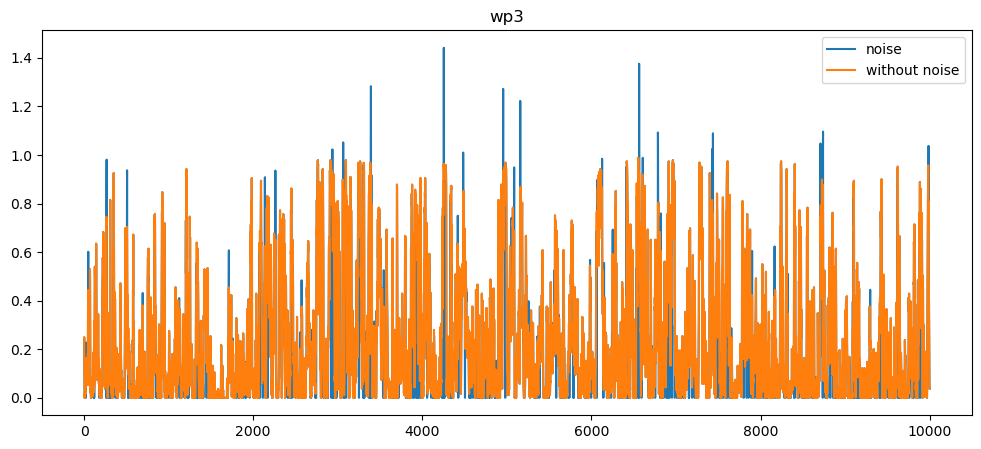

In [7]:
fig = plt.figure(figsize=(12, 5))
plt.plot(range(10000),data_with_noise['wp2'][0:10000],label='noise')
plt.plot(range(10000),data['wp2'][0:10000],label='without noise')
plt.title('wp3')
plt.legend()

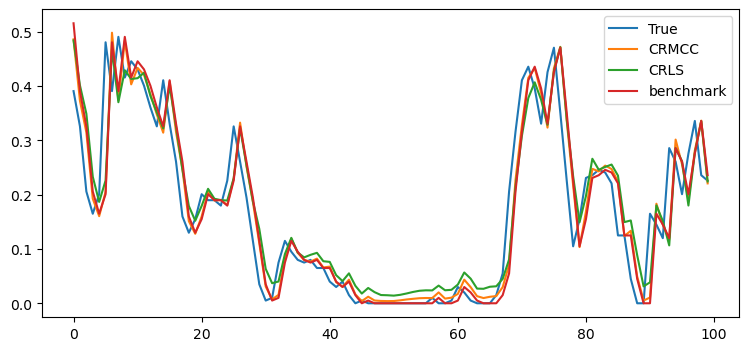

In [383]:
fig = plt.figure(figsize=(9, 4))
plt.plot(range(100),list(y_tot['wp1'][1:101]),label='True')
plt.plot(range(100),list(forecast_tot['CRMCC']['wp1'][1:101]),label='CRMCC')
plt.plot(range(100),list(forecast_tot['CRLS']['wp1'][1:101]),label='CRLS')
plt.plot(range(100),list(y_tot['wp1'][0:100]),label='benchmark')
plt.legend()

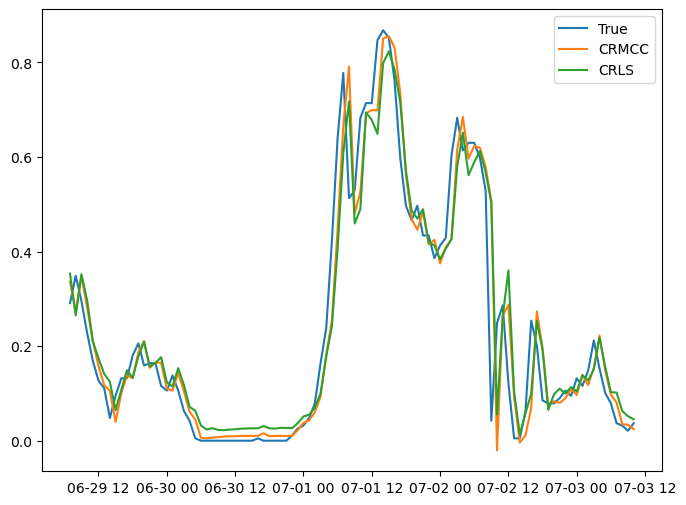

In [384]:
fig = plt.figure(figsize=(8, 6))
plt.plot(y_tot['wp2'][0:100],label='True')
plt.plot(forecast_tot['CRMCC']['wp2'][0:100],label='CRMCC')
plt.plot(forecast_tot['CRLS']['wp2'][0:100],label='CRLS')
plt.legend()

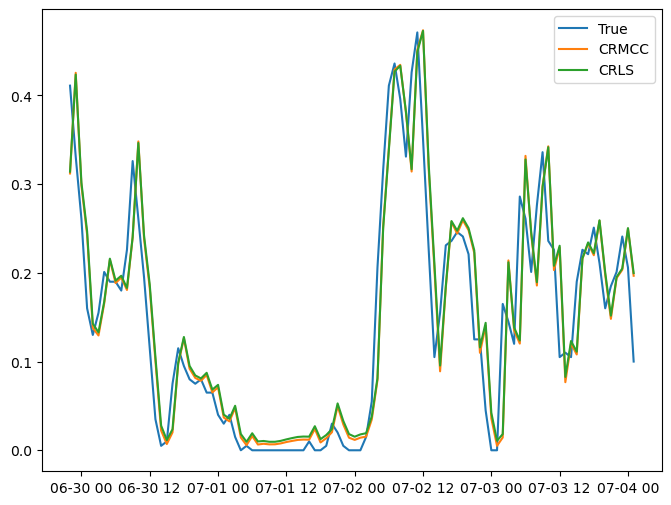

In [ ]:
fig = plt.figure(figsize=(8, 6))
plt.plot(y_tot['wp1'][0:100],label='True')
plt.plot(forecast_tot['CRMCC']['wp1'][0:100],label='CRMCC')
plt.plot(forecast_tot['CRLS']['wp1'][0:100],label='CRLS')
plt.legend()